# Résumé
La reconnaissance faciale est l'une des applications de l'intelligence artificielle. Elle est différente de la détection de visage dans une image qui consiste à trouver la position du visage dans une image. Il s'agit de trouver à qui correpond le visage, de la détection à la classification. Vérifier si la personne présente sur une image est la même que celle dans la base de données.

# Objectif
L'objectif est de déterminer si deux photos représente la même personne ou non.

# Méthode

# Implémentation
Tensorflow & Keras

## Import packages

In [1]:
import os
import math
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from skimage.io import imread
# from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras

In [2]:
tf.__version__

'2.4.1'

## Paths & Config

In [3]:
DATA_DIR = "./data/yalefaces/"
MODEL_PATH = "models/classifier.h5"

WIDTH = 150
HEIGHT = 150
NUM_CHANNELS = 3
VALIDATION_SPLIT = 0.2

LEARNING_RATE = 1e-4
EPOCHS = 10
BATCH_SIZE = 16

## Prepare data

In [4]:
# Listing all files
all_images = os.listdir(DATA_DIR)
# Remove "Readme.txt"
all_images = [image for image in all_images if image!= "Readme.txt"]
# Add extension to filenames
for image in all_images:
    if not image.endswith(".jpg"):
        os.rename(os.path.join(DATA_DIR, image), os.path.join(DATA_DIR, image+".jpg"))
        image = image+".jpg"
print("Total images:", len(all_images))

Total images: 166


In [5]:
data = pd.DataFrame({"image": all_images})
data = data.sample(len(data))
data.head()

,image
67,subject07.happy.jpg
142,subject14.happy.jpg
32,subject09.glasses.jpg
61,subject09.rightlight.jpg
158,subject06.centerlight.jpg


In [6]:
data["image_path"] = DATA_DIR + data["image"]
data.head()

,image,image_path
67,subject07.happy.jpg,./data/yalefaces/subject07.happy.jpg
142,subject14.happy.jpg,./data/yalefaces/subject14.happy.jpg
32,subject09.glasses.jpg,./data/yalefaces/subject09.glasses.jpg
61,subject09.rightlight.jpg,./data/yalefaces/subject09.rightlight.jpg
158,subject06.centerlight.jpg,./data/yalefaces/subject06.centerlight.jpg


In [7]:
data["subject"] = data["image"].apply(lambda x: x.split(".")[0])
data.head()

,image,image_path,subject
67,subject07.happy.jpg,./data/yalefaces/subject07.happy.jpg,subject07
142,subject14.happy.jpg,./data/yalefaces/subject14.happy.jpg,subject14
32,subject09.glasses.jpg,./data/yalefaces/subject09.glasses.jpg,subject09
61,subject09.rightlight.jpg,./data/yalefaces/subject09.rightlight.jpg,subject09
158,subject06.centerlight.jpg,./data/yalefaces/subject06.centerlight.jpg,subject06


In [8]:
data["mode"] = data["image"].apply(lambda x: x.split(".")[1])
data.head()

,image,image_path,subject,mode
67,subject07.happy.jpg,./data/yalefaces/subject07.happy.jpg,subject07,happy
142,subject14.happy.jpg,./data/yalefaces/subject14.happy.jpg,subject14,happy
32,subject09.glasses.jpg,./data/yalefaces/subject09.glasses.jpg,subject09,glasses
61,subject09.rightlight.jpg,./data/yalefaces/subject09.rightlight.jpg,subject09,rightlight
158,subject06.centerlight.jpg,./data/yalefaces/subject06.centerlight.jpg,subject06,centerlight


## Explore data

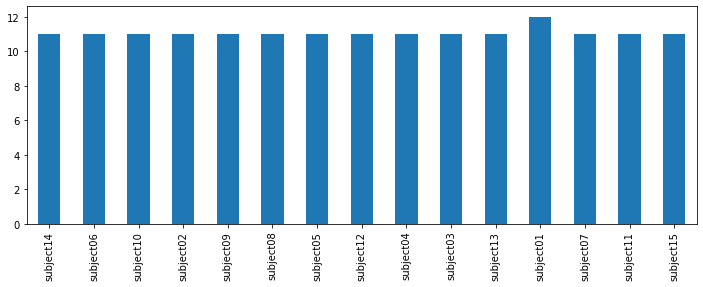

In [9]:
plt.figure(figsize=(12, 4))
data["subject"].value_counts(sort=False).plot(kind="bar")
plt.show()

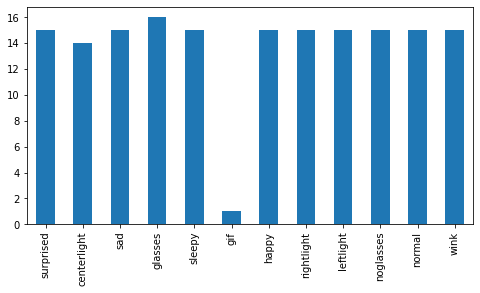

In [10]:
plt.figure(figsize=(8, 4))
data["mode"].value_counts(sort=False).plot(kind="bar")
plt.show()

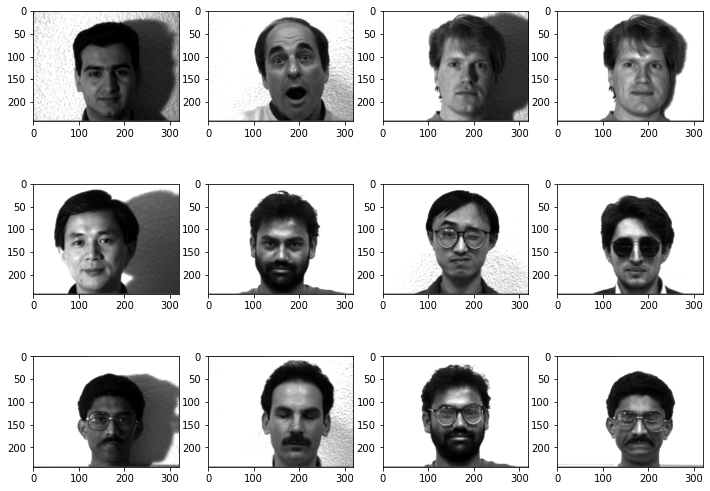

In [11]:
fig = plt.figure(figsize=(12, 9))
for i in range(12):
    fig.add_subplot(3, 4, i+1)
    image = plt.imread(data["image_path"][i])
    plt.imshow(image, cmap="gray")

plt.show()

### Data Geneartor

In [12]:
generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=VALIDATION_SPLIT
)
train_set = generator.flow_from_dataframe(
    dataframe=data,
    x_col="image_path",
    y_col="subject",
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
val_set = generator.flow_from_dataframe(
    dataframe=data,
    x_col="image_path",
    y_col="subject",
    target_size=(WIDTH, HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)
num_classes = len(train_set.class_indices)
print("Total classes:", num_classes)

Found 133 validated image filenames belonging to 15 classes.
Found 33 validated image filenames belonging to 15 classes.
Total classes: 15


## Modèle
Le modèle est constitué de


## Design model

In [13]:
# Use Inception pre-trained model for Transfer Learning
base_model = tf.keras.applications.inception_v3.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(WIDTH, HEIGHT, NUM_CHANNELS))
# Freeze base model weights
base_model.trainable = False

# Build model
model = keras.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(units=1024, activation=tf.nn.relu),
    keras.layers.Dense(units=num_classes, activation=tf.nn.softmax)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 15)                15375     
Total params: 23,916,335
Trainable params: 2,113,551
Non-trainable params: 21,802,784
_________________________________________________________________


## Train model

In [14]:
# Loss & Optimizer
model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.RMSprop(lr=LEARNING_RATE),
              metrics=["accuracy"])
# Training
history = model.fit(train_set, epochs=EPOCHS)

Epoch 1/10
9/9 [==============================] - 56s 3s/step - loss: 2.7495 - accuracy: 0.2139
Epoch 2/10
9/9 [==============================] - 24s 3s/step - loss: 1.2745 - accuracy: 0.6800
Epoch 3/10
9/9 [==============================] - 29s 3s/step - loss: 0.8035 - accuracy: 0.9023
Epoch 4/10
9/9 [==============================] - 33s 4s/step - loss: 0.6612 - accuracy: 0.8861
Epoch 5/10
9/9 [==============================] - 31s 3s/step - loss: 0.3518 - accuracy: 0.9846
Epoch 6/10
9/9 [==============================] - 27s 3s/step - loss: 0.2652 - accuracy: 0.9847
Epoch 7/10
9/9 [==============================] - 26s 3s/step - loss: 0.1964 - accuracy: 0.9921
Epoch 8/10
9/9 [==============================] - 26s 3s/step - loss: 0.1210 - accuracy: 1.0000
Epoch 9/10
9/9 [==============================] - 30s 3s/step - loss: 0.0810 - accuracy: 1.0000
Epoch 10/10
9/9 [==============================] - 29s 3s/step - loss: 0.1141 - accuracy: 1.0000


## Evaluate model

In [15]:
_ = model.evaluate(val_set)

3/3 [==============================] - 26s 2s/step - loss: 0.6120 - accuracy: 0.8182


## Save model

In [16]:
model.save(MODEL_PATH)

## Next steps
1. 

# Conclusion